## Deep Learning for Text Classification
#### This program originates from the tutorial of tensorflow: https://www.tensorflow.org/tutorials/keras/basic_text_classification
####  Based on the needs of study, the following modifications are made:
1. Replace the data from my mock dataset.
2. Try the following scenarios:
   1) Found out the predicted categories is not correct, and reassigned it, and verify this reassignment works without 
      impact previous prediction of other records.
   2) The predicted category does not exist, create new one, and verify this creation works without impact others.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding,LSTM
from keras.preprocessing import text, sequence
from keras import utils

# This code was tested with TensorFlow v1.4
print("You have TensorFlow version", tf.__version__)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


You have TensorFlow version 1.12.0


Using TensorFlow backend.


### Load the mock dataset

In [3]:
df = pd.read_excel('../98_data/qalist_answer.xlsx', encoding='latin-1')
df.head()

,question,answer
0,I have the problem on The field city could not...,"The system setting is missing, and it is corre..."
1,I have the problem on The field city could not...,"The system setting is missing, and it is corre..."
2,I have the problem on The field city could not...,"The system setting is missing, and it is corre..."
3,I have the problem on The field city could not...,"The system setting is missing, and it is corre..."
4,I have the problem on The field city could not...,"The system setting is missing, and it is corre..."


In [4]:
# Rename the columns
df.columns=['Emails', 'Cat']
col = ['Emails', 'Cat']
df = df[pd.notnull(df['Emails'])]
df.head()

,Emails,Cat
0,I have the problem on The field city could not...,"The system setting is missing, and it is corre..."
1,I have the problem on The field city could not...,"The system setting is missing, and it is corre..."
2,I have the problem on The field city could not...,"The system setting is missing, and it is corre..."
3,I have the problem on The field city could not...,"The system setting is missing, and it is corre..."
4,I have the problem on The field city could not...,"The system setting is missing, and it is corre..."


In [5]:
df.isnull().sum()

Emails    0
Cat       0
dtype: int64

In [6]:
df['Cat'].value_counts()

The system bug and it is working now after applying patch.                                                      5808
The system change was done, and this field was removed. Please check the annoucement sent last month.           3872
The system setting is missing, and it is corrected after reinputting it.                                        3872
The role was not changes since the change was not transferred to system.It was done, and should be work now.    3872
The system maintenance was completed, and it is working now.                                                    1936
Please clear your IE cache, if not work, please upgrade your windows to windows 10.                              484
The system setting was changed, and we will restore the system setting, after that, please try it again.         242
Your authorization is insufficient, please apply for the additional authorizations.                              242
Name: Cat, dtype: int64

In [7]:
# Split data into train and test
train_size = int(len(df) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(df) - train_size))

Train size: 16262
Test size: 4066


### Convert the words to integers

In [8]:
train_narrative = df['Emails'][:train_size]
train_product = df['Cat'][:train_size]

test_narrative = df['Emails'][train_size:]
test_product = df['Cat'][train_size:]

In [9]:
# Open question: why the max_words is required?
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [10]:
tokenize.fit_on_texts(train_narrative) # only fit on train
x_train = tokenize.texts_to_matrix(train_narrative)
x_test = tokenize.texts_to_matrix(test_narrative)

In [11]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_product)
y_train = encoder.transform(train_product)
y_test = encoder.transform(test_product)

In [12]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [13]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (16262, 1000)
x_test shape: (4066, 1000)
y_train shape: (16262, 8)
y_test shape: (4066, 8)


### Build the model

In [33]:
# Open questions: why are those parameters used for?
batch_size = 32
epochs = 5

In [34]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

### Loss function and optimizer
A model needs a loss function and an optimizer for training. Since this is a categorical classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use the categorical_crossentropy loss function.
This isn't the only choice for a loss function, you could, for instance, choose mean_squared_error. But, generally, categorical_crossentropy is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.
Later, when we are exploring regression problems (say, to predict the price of a house), we will see how to use another loss function called mean squared error.
Now, configure the model to use an optimizer and a loss function:

In [35]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Train the model

In [36]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 14636 samples, validate on 1627 samples
Epoch 1/5
14636/14636 [==============================] - 2s 167us/step - loss: 0.1507 - acc: 0.9680 - val_loss: 0.0078 - val_acc: 0.9994
Epoch 2/5
14636/14636 [==============================] - 2s 140us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 0.9994
Epoch 3/5
14636/14636 [==============================] - 2s 140us/step - loss: 5.0582e-04 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 0.9994
Epoch 4/5
14636/14636 [==============================] - 2s 142us/step - loss: 2.4037e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 0.9994
Epoch 5/5
14636/14636 [==============================] - 2s 143us/step - loss: 1.3542e-04 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 0.9994


In [37]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

4066/4066 [==============================] - 0s 52us/step
Test score: 0.0004928920992908819
Test accuracy: 1.0


### Create a graph of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [38]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

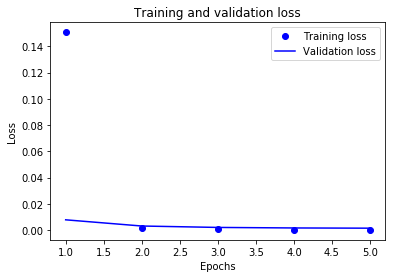

In [39]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

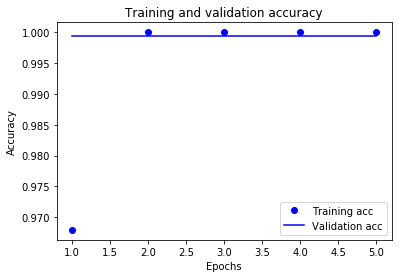

In [40]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.
Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.
This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.
For this particular case, we could prevent overfitting by simply stopping the training after twenty or so epochs. Later, you'll see how to do this automatically with a callback.

### Evaluate model

#### Scenario 1: Verify 10 records in test dataset

In [41]:
# Here's how to generate a prediction on individual examples
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_narrative.iloc[i][:50], "...")
    print('Actual label:' + test_product.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

It is really frastruted to meet with the following ...
Actual label:The system change was done, and this field was removed. Please check the annoucement sent last month.
Predicted label: The system change was done, and this field was removed. Please check the annoucement sent last month.

It is really frastruted to meet with the following ...
Actual label:The system change was done, and this field was removed. Please check the annoucement sent last month.
Predicted label: The system change was done, and this field was removed. Please check the annoucement sent last month.

It is really frastruted to meet with the following ...
Actual label:The system change was done, and this field was removed. Please check the annoucement sent last month.
Predicted label: The system change was done, and this field was removed. Please check the annoucement sent last month.

It is really frastruted to meet with the following ...
Actual label:The system change was done, and this field was removed. Please

#### Scenario 2: Change the predicted category

##### Step 1: Input 2 sentences to predict the categories based on the built model, and jot down the predictions.

In [42]:
input_sentence = ''
while(1):
    try:
        # Get input sentence
        input_sentence = input('> ')
        # Check if it is quit case
        if input_sentence == 'q' or input_sentence == 'quit': 
            break
        # Normalize sentence
        input_sentence = tokenize.texts_to_matrix([input_sentence])       
        pred_output = model.predict(np.array(input_sentence))
        pred_prob=model.predict_proba(np.array(input_sentence))
        predicted_label = text_labels[np.argmax(pred_output)]
        print('Bot:', ' '.join([predicted_label,'Probality:',str(pred_prob[0,np.argmax(pred_output)])]))
        """
        input_confirmation = input('Proposal accepted? (y/n) ')
        # Check if it is quit case
        if input_confirmation == 'n': 
            input_confirmation = input('Which is better? (0-7)')
        """
    except KeyError:
        print("Error: Encountered unknown word.")

> my ie could be opened
Bot: The system setting is missing, and it is corrected after reinputting it. Probality: 0.6635773
> my authorization is not sufficient
Bot: The role was not changes since the change was not transferred to system.It was done, and should be work now. Probality: 0.6771141
> q


#####  Step 2: Input 1 more sentence to predict the category based on the built model, and jot down its prediction.

In [43]:
prediction_input = model.predict(np.array(input_test))
prediction_prob=model.predict_proba(np.array(input_test))
predicted_label = text_labels[np.argmax(prediction_input)]
print(predicted_label,prediction_prob)
encoder.classes_

The system setting is missing, and it is corrected after reinputting it. [[0.15078942 0.05951954 0.04673667 0.02765448 0.00923906 0.62884533
  0.03243705 0.04477842]]


array(['Please clear your IE cache, if not work, please upgrade your windows to windows 10.',
       'The role was not changes since the change was not transferred to system.It was done, and should be work now.',
       'The system bug and it is working now after applying patch.',
       'The system change was done, and this field was removed. Please check the annoucement sent last month.',
       'The system maintenance was completed, and it is working now.',
       'The system setting is missing, and it is corrected after reinputting it.',
       'The system setting was changed, and we will restore the system setting, after that, please try it again.',
       'Your authorization is insufficient, please apply for the additional authorizations.'],
      dtype=object)

In [44]:
# Fixed previous weights without changing prediction, but may have reassigned the lable in this senarioes.
model.layers[0].trainable=False
model.layers[3].trainable=False
for layer in model.layers:
    print(layer.name, layer.trainable)

dense_3 False
activation_3 True
dropout_2 True
dense_4 False
activation_4 True


In [45]:
input_narratives=['My IE window could not be opened']
input_test = tokenize.texts_to_matrix(input_narratives)

In [46]:
## Retrain the model by combining the preivous dataset and revised data record.
batch_size = 32
epochs = 5
predict_y=np.argmax(prediction_input)
predict_y=0
y_output = utils.to_categorical([predict_y], num_classes)
print(np.argmax(prediction_input))
print(y_output)
x_train=np.vstack([x_train,input_test])
y_train=np.vstack([y_train,y_output])
"""
retrain = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)
"""

retrain = model.fit([input_test], [y_output],
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

prediction_input = model.predict(np.array(input_test))
prediction_prob=model.predict_proba(np.array(input_test))
predicted_label = text_labels[np.argmax(prediction_input)]
print(predicted_label,prediction_prob)

5
[[1. 0. 0. 0. 0. 0. 0. 0.]]
Epoch 1/5
1/1 [==============================] - 0s 5ms/step - loss: 2.2321 - acc: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 1.8568 - acc: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 0.6713 - acc: 1.0000
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 0.4948 - acc: 1.0000
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 0.2162 - acc: 1.0000
Please clear your IE cache, if not work, please upgrade your windows to windows 10. [[0.9114187  0.01596541 0.01239324 0.01042774 0.00306151 0.02600848
  0.0096537  0.01107118]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


#####  Step 3: Change the predicted category, and retrain the model by adding the new records into the dataset.

In [47]:
encoder.classes_

array(['Please clear your IE cache, if not work, please upgrade your windows to windows 10.',
       'The role was not changes since the change was not transferred to system.It was done, and should be work now.',
       'The system bug and it is working now after applying patch.',
       'The system change was done, and this field was removed. Please check the annoucement sent last month.',
       'The system maintenance was completed, and it is working now.',
       'The system setting is missing, and it is corrected after reinputting it.',
       'The system setting was changed, and we will restore the system setting, after that, please try it again.',
       'Your authorization is insufficient, please apply for the additional authorizations.'],
      dtype=object)

#####  Step 4: Re-input the 2 sentences in the step 2, and the result should show one category will be changed, and other is kept unchange.

In [48]:
input_sentence = ''
while(1):
    try:
        # Get input sentence
        input_sentence = input('> ')
        # Check if it is quit case
        if input_sentence == 'q' or input_sentence == 'quit': 
            break
        # Normalize sentence
        input_sentence = tokenize.texts_to_matrix([input_sentence])       
        pred_output = model.predict(np.array(input_sentence))
        pred_prob=model.predict_proba(np.array(input_sentence))
        predicted_label = text_labels[np.argmax(pred_output)]
        print('Bot:', ' '.join([predicted_label,'Probality:',str(prediction_prob[0,np.argmax(pred_output)])]))
        """
        input_confirmation = input('Proposal accepted? (y/n) ')
        # Check if it is quit case
        if input_confirmation == 'n': 
            input_confirmation = input('Which is better? (0-7)')
        """
    except KeyError:
        print("Error: Encountered unknown word.")

> my ie could not be opened
Bot: Please clear your IE cache, if not work, please upgrade your windows to windows 10. Probality: 0.9114187
> my authorization is not sufficient
Bot: The role was not changes since the change was not transferred to system.It was done, and should be work now. Probality: 0.015965406
> q
